In [35]:
import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#plt.style.use('dark_background')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

!pip install yfinance

from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime

yf.pdr_override()

df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show the data
df.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.500193,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.567370,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.706894,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.839728,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.819360,394024400


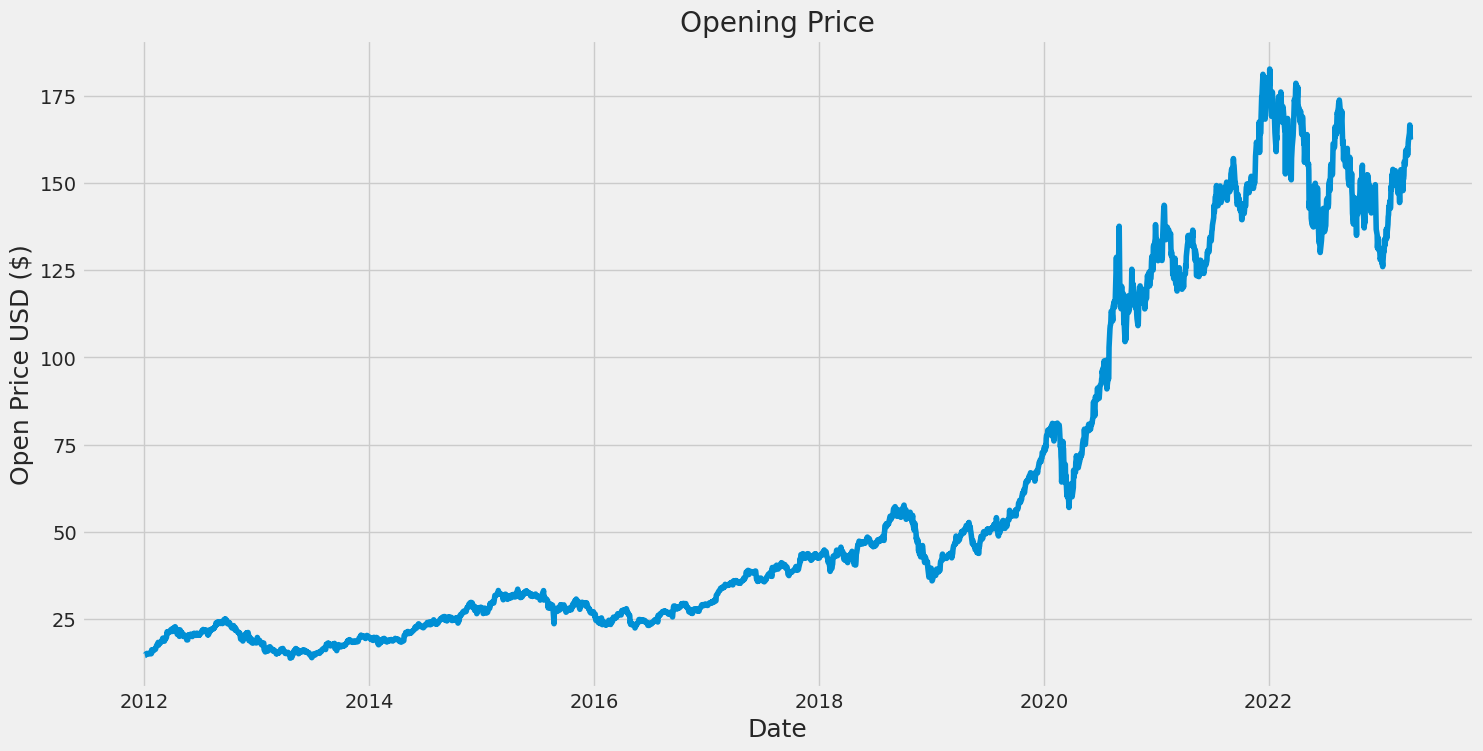

In [36]:
plt.figure(figsize=(16,8))
plt.title('Opening Price')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

In [37]:
data=df.filter(['Low'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on & math.ceil to round up 
training_data_len = math.ceil(len(dataset)*.8)

#print(dataset)
training_data_len

2268

In [38]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

#Create scaled training dataset
train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set
x_train=[]
y_train=[]
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.00516171, 0.00522217, 0.00595431, 0.00736892, 0.00782894,
       0.00786133, 0.00738836, 0.00726741, 0.00724798, 0.00817665,
       0.008898  , 0.00894335, 0.00748338, 0.00803411, 0.00744019,
       0.01266236, 0.01253494, 0.01267101, 0.01302087, 0.01467952,
       0.01521514, 0.01487606, 0.0152173 , 0.01578746, 0.01716534,
       0.01827112, 0.02061656, 0.02234216, 0.02418655, 0.02524697,
       0.02414336, 0.0219275 , 0.02487982, 0.02570483, 0.02677387,
       0.02686675, 0.02884072, 0.02833103, 0.03039787, 0.03252518,
       0.0331882 , 0.03399809, 0.03043026, 0.02831807, 0.02984714,
       0.031752  , 0.03412552, 0.03496564, 0.03685538, 0.04109921,
       0.04177952, 0.04166073, 0.04404721, 0.04457202, 0.04671661,
       0.0454467 , 0.04520265, 0.04538839, 0.04772087, 0.04863874])]
[0.047973560026183276]



In [39]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2208, 60, 1)

In [40]:
#Build LSTM model
model=Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1,epochs=3)

Epoch 1/3
2208/2208 [==============================] - 97s 41ms/step - loss: 6.9625e-04
Epoch 2/3
2208/2208 [==============================] - 78s 35ms/step - loss: 3.1679e-04
Epoch 3/3
2208/2208 [==============================] - 76s 34ms/step - loss: 2.3119e-04


In [41]:
#Create the test data set
#Create a new array containing scaled values
test_data=scaled_data[training_data_len-60: , : ]

#Create the data sets x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
#Convert the data to a numpy array
x_test=np.array(x_test)
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)
#Get root mean squared error(RMSE)
rmse =np.sqrt(np.mean(predictions-y_test)**2)
rmse

18/18 [==============================] - 1s 24ms/step


6.779475154809312

In [42]:
#open = 4.397517349189246
#high = 18.77345060206976
#close = 11.5129595375735
#Adj Close = 14.814079716011829
#Low = 6.779475154809312